# DL: Deep learning with *BioImage.IO*
[BioImageIO](https://bioimage.io/) is a fantasic project to bring ML/DL to bioimages. It is a hub for datasets and models specific to bioimage applications. We will fetch a deep neural network using its API and test it on our own images.
<!-- Though they provide links to datasets, unfortunately they do not teach you how to load them  -->

This notebook is almost identical to [this example](https://github.com/bioimage-io/core-bioimage-io-python/blob/0385d873b5705779cf205106c022e559d44b8f79/example/bioimageio-core-usage.ipynb) provided by from BioImageIO team, except for `bioimageloader` part.

Note that it is fine not to have GPU setup to run this notebook, but to process a lot of images it is recommended to use GPU acceleration. This model requires [PyTorch](https://pytorch.org/) (`torch`) for that. Once you installed it, this notebook will automatically detect GPU(s) on your machine.

## Install dependencies and Imports
We are going to use venerable `matplotlib` instead of `napari` to embed figures in this notebook, but `napari` (https://napari.org/) is definetly a right choice!

In [1]:
# !pip install bioimageio.core
# !pip install matplotlib
#   or better yet install napari!
# !pip install napari

In [2]:
import os
import hashlib

import albumentations as A
import bioimageio.core
import imageio
# we use napari for visualising images, you can install it via `pip install napari` or`conda install napari`
#import napari
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr  # dependency of bioimageio.core, will be installed automatically

from bioimageio.core.prediction_pipeline import create_prediction_pipeline

from bioimageloader import (Config, datasets_from_config, ConcatDataset,
                            BatchDataloader)
from bioimageloader.transforms import HWCToCHW, SqueezeGrayImageCHW

## Load a model through bioimage.io API
We will use a model that predicts foreground and boundaries in images of nuclei from the kaggle nucles segmentation challenge. Find the model on bioimage.io here: https://bioimage.io/#/?id=10.5072%2Fzenodo.881940 (if it does not work, click [this link](https://deploy-preview-199--bioimage.netlify.app/?tags=dsb&id=10.5072%2Fzenodo.881940#/?tags=dsb&id=10.5072%2Fzenodo.881940)).

`bioimage.io` uses what they call RDF (resource description file) which contains all the necessary information of a model. We are going to use it to download the model as well as a sample image.

In [3]:
rdf_doi = "10.5072/zenodo.881940"
model_resource = bioimageio.core.load_resource_description(rdf_doi)

/home/seongbinlim/miniconda3/envs/bioio/lib/python3.9/site-packages/bioimageio/spec/shared/schema.py:45: ValidationWarning: weights:torchscript: missing 'pytorch_version'
  warnings.warn(msg, category=ValidationWarning)
zero_mean_unit_variance.ijm: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 845/845 [00:00<00:00, 415kiB/s]
cover.jpg: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17.6k/17.6k [00:00<00:00, 6.84MiB/s]
documentation.md: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95.0/95.0 [00:00<00:00, 47.0kiB/s]
sample_input.tif: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [4]:
# print info if you want
model_resource.__dict__

{'format_version': '0.4.3',
 'name': 'DSB-Nuclei-BoundaryModel',
 'type': 'model',
 'version': StrictVersion ('0.1'),
 'root_path': PosixPath('/home/seongbinlim/workspace/bioimageloader/notebooks'),
 'attachments': Attachments(files=[PosixPath('/tmp/bioimageio_cache/https/sandbox.zenodo.org/api/files/782ae236-8146-44fe-b2ac-a16314dcd7e2/zero_mean_unit_variance.ijm')], unknown={}),
 'authors': [Author(name='Constantin Pape; @constantinpape', affiliation=<marshmallow.missing>, email=<marshmallow.missing>, github_user=<marshmallow.missing>, orcid=<marshmallow.missing>)],
 'badges': <marshmallow.missing>,
 'cite': [CiteEntry(text='training library', doi=<marshmallow.missing>, url='https://github.com/constantinpape/torch-em.git'),
  CiteEntry(text='architecture', doi=<marshmallow.missing>, url='https://doi.org/10.1007/978-3-319-24574-4_28'),
  CiteEntry(text='segmentation algorithm', doi=<marshmallow.missing>, url='https://doi.org/10.1038/nmeth.4151'),
  CiteEntry(text='data', doi=<marshmal

In [5]:
# the "model_resource" instance returned by load_resource_description
# contains the information stored in the resource description (see https://github.com/bioimage-io/spec-bioimage-io/blob/gh-pages/model_spec_latest.md)

# we can e.g. check what weight formats are available in the model (pytorch_state_dict for the model used here)
print("Available weight formats for this model:", model_resource.weights.keys())
# or how the weight files are stored
print("Pytorch state dict weights are stored at:", model_resource.weights["pytorch_state_dict"].source)
print()
# or what inputs the model expects
print("The model requires as inputs:")
for inp in model_resource.inputs:
    print("Input with axes:", inp.axes, "and shape", inp.shape)
print()
# and what the model outputs are
print("The model returns the following outputs:")
for out in model_resource.outputs:
    print("Output with axes:", out.axes, "and shape", out.shape)

Available weight formats for this model: dict_keys(['pytorch_state_dict', 'torchscript'])
Pytorch state dict weights are stored at: /tmp/bioimageio_cache/https/sandbox.zenodo.org/api/files/782ae236-8146-44fe-b2ac-a16314dcd7e2/weights.pt

The model requires as inputs:
Input with axes: ('b', 'c', 'y', 'x') and shape ParametrizedInputShape(min=[1, 1, 32, 32], step=[0, 0, 16, 16])

The model returns the following outputs:
Output with axes: ('b', 'c', 'y', 'x') and shape ImplicitOutputShape(reference_tensor='input', scale=[1.0, 2.0, 1.0, 1.0], offset=[0.0, 0.0, 0.0, 0.0])


In [6]:
# the function 'test_model' from 'bioimageio.core.resource_tests' can be used to fully test the model,
# including running prediction for the test input(s) and checking that they agree with the test output(s)
# before using a model, it is recommended to check that it properly works with this function
# 'test_model' returns a dict, if there are any errros they will be in the key "error"
# if the model passes it will be None
from bioimageio.core.resource_tests import test_model
test_result = test_model(model_resource)
if test_result["error"]:
    print("The model test failed with:", test_result["error"])
    print("with the traceback:", test_result["traceback"])
else:
    print("The model passed all tests")

The model passed all tests


## Run model with a sample image
The model comes with a sample image. We are going to test the model with it. We can deduce from the sample image that this model would expect `(b, 1, h, w)` shape of image(s) (number of channel being 1 means grayscale image).

In [7]:
# load the example image for this model, which is stored in numpy file format
input_image = np.load(model_resource.test_inputs[0])

(1, 1, 256, 256) uint8


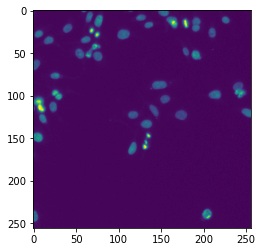

In [8]:
plt.imshow(input_image.squeeze())
# We should have a right shape (b, 1, h, w) and dtype
print(input_image.shape, input_image.dtype)

In [9]:
# define a function to run prediction on a numpy input
# "devices" can be used to run prediction on a gpu instead of the cpu
# "weight_format" to specify which weight format to use in case the model contains different weight formats
def predict_numpy(model, input_, devices=None, weight_format=None):
    # the prediction pipeline combines preprocessing, prediction and postprocessing.
    # it should always be used for prediction with a bioimageio model
    pred_pipeline = create_prediction_pipeline(
        bioimageio_model=model, devices=devices, weight_format=weight_format
    )

    # the prediction pipeline expects inputs as xarray.DataArrays.
    # these are similar to numpy arrays, but allow for named dimensions (the dims keyword argument)
    # in bioimage.io the dims have to agree with the input axes required by the model
    axes = tuple(model.outputs[0].axes)
    input_tensor = xr.DataArray(input_, dims=axes)
    
    # the prediction pipeline call expects the same number of inputs as the number of inputs required by the model
    # in the case here, the model just expects a single input. in the case of multiple inputs use
    # prediction = pred_pipeline(input1, input2, ...)
    # or, if you have the inputs in a list or tuple
    # prediction = pred_pipeline(*inputs)
    # the call returns a list of output tensors, corresponding to the output tensors of the model
    # (in this case, we just have a single output)
    prediction = pred_pipeline(input_tensor)[0]
    return prediction

Text(0.5, 1.0, 'prediction')

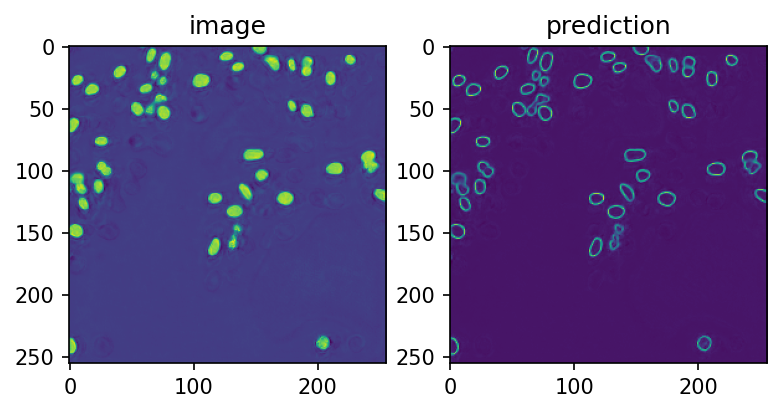

In [10]:
# run prediction for the test input and show the result
prediction = predict_numpy(model_resource, input_image)

fig, ax = plt.subplots(ncols=2, dpi=150)
ax[0].imshow(prediction[0, 0])
ax[0].set_title('image')
ax[1].imshow(prediction[0, 1])
ax[1].set_title('prediction')

## Run with *bioimageloader*
Now it's time to show power of `bioimageloder`. We can easily iterate any images from `bioimageloader.collections`.

As an example we can load `BBBC041` (https://bbbc.broadinstitute.org/bbbc041) and test the model on them. Note that this dataset has RGB channel, which the model does not expect, thus it needs extra processing, especially RGBtoGray conversion. So we will pass `grayscale` argument.

In [11]:
# give a path to dataset and set grayscale=True
cfg = {
    'BBBC041': {
        'root_dir': '../Data/bbbc/041',
        'grayscale': True
    },
}

Additionally, we need some juggling to match the requirement of the model, becuase the model expects

1. To have `(b, 1, h, w)` shape

    > Ignore b(=batch) for the moment. First we will use
    > `bioimageloader.transforms.HWCToCHW` to transform an image that has
    > `(h, w, 3)`, which is the default shape from `bioimageloader`, into
    > `(3, h, w)`. Then, we will pick only one channel using
    > `bioimageloader.transforms.SqueezeGrayImageCHW`. This will preserve the
    > number of channel to be 1, so that the final shape could be `(1, h, w)`.
    
2. To be a numpy.ndarray

    > `bioimageloader` already returns numpy array!
    
3. To have dtype=uint8

    > This, as well, a default of `bioimageloader`.

Plus, we will resize images to have (256, 256), just to reduce the size (each image of BBBC041 originally has over (1000, 1000) pixels).

In [12]:
transforms = A.Compose([
    A.Resize(256, 256),
    HWCToCHW(),            # from (h, w, 3) to (3, h, w)
    SqueezeGrayImageCHW()  # from (3, h, w) to (1, h, w)
])

datasets = datasets_from_config(cfg, transforms=transforms)
for dset in datasets:
    print(f'{dset.acronym:10s}: {len(dset):10d}')

BBBC041   :       1208


Use `bioimageloader.BatchDataloader` to load data in batch

In [13]:
# Feel free to adjust
BATCH_SIZE = 4
NUM_WORKERS = 2

In [14]:
bbbc041 = datasets[0]
loader = BatchDataloader(bbbc041,
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS)
iter_loader = iter(loader)

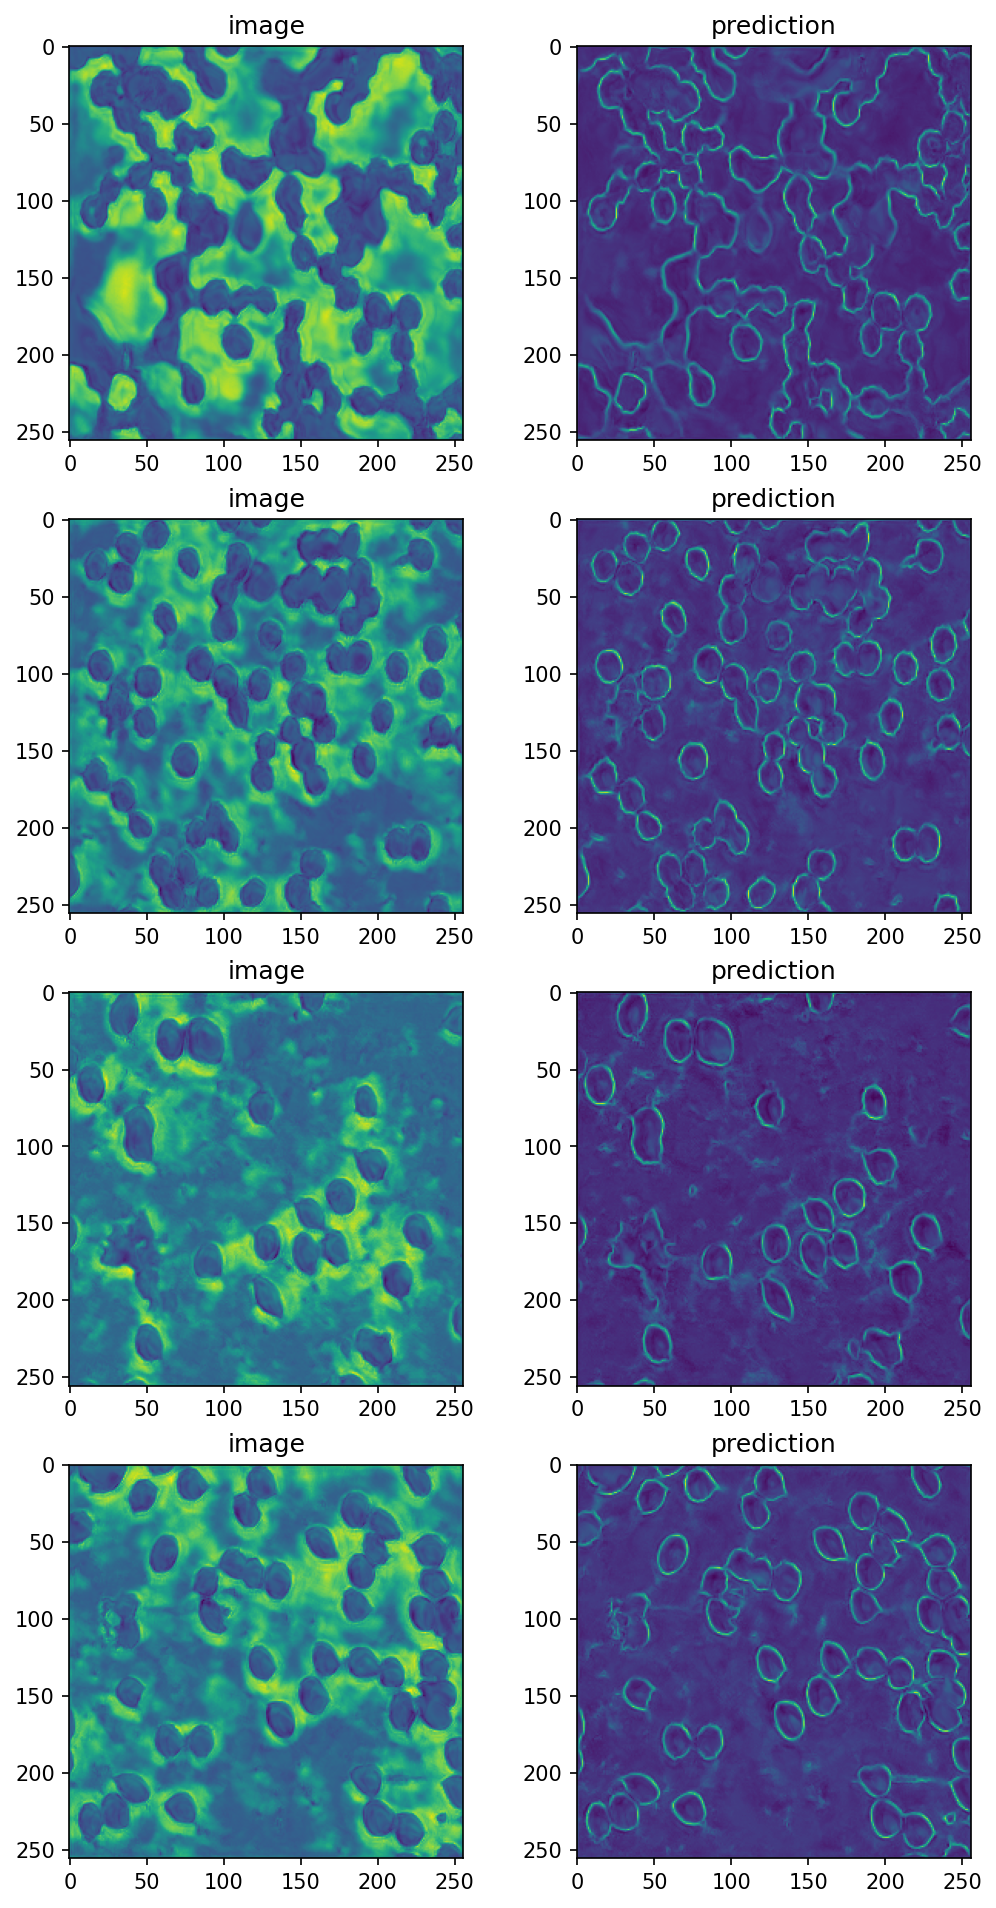

In [15]:
data = next(iter_loader)

input_image = data['image']
# will have shape (BATCH_SIZE, 1, 256, 256)

# run prediction for the test input and show the result
prediction = predict_numpy(model_resource, input_image)

fig, ax = plt.subplots(nrows=BATCH_SIZE, ncols=2,
                       figsize=[8, 4*BATCH_SIZE],
                       dpi=150)
for i, pred in enumerate(prediction):
    ax[i, 0].imshow(prediction[i, 0])
    ax[i, 0].set_title('image')
    ax[i, 1].imshow(prediction[i, 1])
    ax[i, 1].set_title('prediction')

Voilà !